In [1]:
from pandas import read_csv, concat, DataFrame, to_datetime
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
from os.path import expanduser
from os import stat
from glob import glob
from pandas import Timestamp
from numpy import sin, cos, pi
from numpy import array, copy, mean, std
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

def get_files(fn):
    path = 'dataset/'
    files = glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]


# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if stat(f).st_size != 0:
            # create df
            temp = read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = concat(list_of_pandas, ignore_index=True)
    df.index = to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

## Import and preprocess data

In [2]:
# list files
# demand_files = get_files('demand')
source_files = get_files('sources')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in source_files]

# get data from files
# demands = parse_file(demand_files, filenames)
sources = parse_file(source_files, filenames)

In [3]:
# move values and drop temp cols
sources['Natural gas'].fillna(sources['Natural Gas'], inplace=True)
sources['Large hydro'].fillna(sources['Large Hydro'], inplace=True)
sources.drop(columns=['Natural Gas', 'Large Hydro'], inplace=True)

# Linear interpolatio for missing data
sources.interpolate(method='linear', axis=0, inplace=True)

In [4]:
sources.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other
2019-01-01 00:00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0
2019-01-01 00:05:00,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0
2019-01-01 00:10:00,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0
2019-01-01 00:15:00,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0
2019-01-01 00:20:00,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0


### Split columns to renewable and non-renewable 
### and create multivariate x and y components

In [5]:
non_renewable = ['Coal', 'Nuclear', 'Natural gas']

df = DataFrame(sources[non_renewable], columns=non_renewable)

# create signal columns with the sin cos teqnuiche
day = 60*60*24
year = 365.2425*day
df['Seconds'] = df.index.map(Timestamp.timestamp)
df['Day sin'] = sin(df['Seconds'] * (2* pi / day))
df['Day cos'] = cos(df['Seconds'] * (2 * pi / day))
df['Year sin'] = sin(df['Seconds'] * (2 * pi / year))
df['Year cos'] = cos(df['Seconds'] * (2 * pi / year))
df = df.drop('Seconds', axis=1)

df.head()

,Coal,Nuclear,Natural gas,Day sin,Day cos,Year sin,Year cos
2019-01-01 00:00:00,11.0,2273.0,7326.0,-5.030095e-12,1.000000,0.002021,0.999998
2019-01-01 00:05:00,11.0,2273.0,7200.0,2.181489e-02,0.999762,0.002081,0.999998
2019-01-01 00:10:00,11.0,2272.0,7057.0,4.361939e-02,0.999048,0.002141,0.999998
2019-01-01 00:15:00,11.0,2272.0,7007.0,6.540313e-02,0.997859,0.002201,0.999998
2019-01-01 00:20:00,11.0,2273.0,6970.0,8.715574e-02,0.996195,0.002260,0.999997


### Convert data to tensor for multi-step forecasting technique

In [6]:
def df_to_tensor(df, window_size):
    data = df.to_numpy()
    X, y = [], []
    for i in range(data.shape[0]-window_size):
        row = [r for r in data[i:i+window_size]]
        label = [data[i+window_size][0], data[i+window_size][1], data[i+window_size][2]]
        X.append(row)
        y.append(label)
    return array(X), array(y)

In [7]:
WINDOW_SIZE = 8
X, y = df_to_tensor(df, WINDOW_SIZE)
X[0][0]

array([ 1.10000000e+01,  2.27300000e+03,  7.32600000e+03, -5.03009464e-12,
        1.00000000e+00,  2.02132493e-03,  9.99997957e-01])

In [8]:
print(y[0])

[  11. 2274. 6789.]


In [9]:
X.shape, y.shape

((315640, 8, 7), (315640, 3))

### Split to train with the first 2 years and test the 3rd

In [10]:
# 2 full years per hour data
#X_train, y_train = X[:210527], y[:210527]
#X_test, y_test = X[210527:], y[210527:]
# X_val, y_val = X[290000:], y[290000:]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((211478, 8, 7), (211478, 3), (104162, 8, 7), (104162, 3))

### Applying standardization to the data

In [12]:
# find mean and std for each dimension (except cos sin cols, they're alredy standardized)

coal_train_mean = mean(X_train[:, :, 0])
coal_train_std = std(X_train[:, :, 0])

nucl_train_mean = mean(X_train[:, :, 1])
nucl_train_std = std(X_train[:, :, 1])

ngas_train_mean = mean(X_train[:, :, 2])
ngas_train_std = std(X_train[:, :, 2])

print(coal_train_std, nucl_train_std, ngas_train_std)


def preprocess_input(X):
    X[:, :, 0] = (X[:, :, 0] - coal_train_mean) / coal_train_std
    X[:, :, 1] = (X[:, :, 1] - nucl_train_mean) / nucl_train_mean
    X[:, :, 2] = (X[:, :, 2] - ngas_train_mean) / ngas_train_mean

def preprocess_output(y):
    y[:, 0] = (y[:, 0] - coal_train_mean) / coal_train_std
    y[:, 1] = (y[:, 1] - nucl_train_mean) / nucl_train_mean
    y[:, 2] = (y[:, 2] - ngas_train_mean) / ngas_train_mean
    return y

4.575404416240695 578.4753346153658 3948.092116599419


In [13]:
preprocess_input(X_train)
preprocess_input(X_test)

print(X_train[0, 0, :])
print(X_test[0, 0, :])

[ 1.25742339  0.20452497  0.50332157  0.96004985 -0.27982901 -0.74141443
 -0.67104742]
[ 0.60174364 -0.38863666 -0.13642822 -0.88701083 -0.46174861  0.65227338
  0.7579838 ]


In [14]:
preprocess_output(y_train)
preprocess_output(y_test)

print(y_train[0, :])
print(y_test[0, :])

[1.4759833  0.20398963 0.54420285]
[ 0.60174364 -0.38810131  0.17868322]


### Model creation

In [18]:
model = Sequential()
model.add(InputLayer((X.shape[1], X.shape[2])))
model.add(LSTM(64))
model.add(Dense(8, 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(3, 'linear', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18432     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 18,979
Trainable params: 18,979
Non-trainable params: 0
_________________________________________________________________


### Apply model

In [19]:
cp = ModelCheckpoint('model/', save_best_only=True)
es = EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

### Fit the model

In [20]:
history = model.fit(X_train, y_train, validation_split=0.33, epochs=20, callbacks=[cp, es], shuffle=False)

Epoch 1/20
4428/4428 [==============================] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.1243

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4428/4428 [==============================] - 28s 6ms/step - loss: 0.0408 - root_mean_squared_error: 0.1243 - val_loss: 0.0411 - val_root_mean_squared_error: 0.1357
Epoch 2/20
4426/4428 [============================>.] - ETA: 0s - loss: 0.0355 - root_mean_squared_error: 0.1109

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4428/4428 [==============================] - 26s 6ms/step - loss: 0.0355 - root_mean_squared_error: 0.1109 - val_loss: 0.0411 - val_root_mean_squared_error: 0.1353
Epoch 3/20
4418/4428 [============================>.] - ETA: 0s - loss: 0.0352 - root_mean_squared_error: 0.1100

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4428/4428 [==============================] - 26s 6ms/step - loss: 0.0352 - root_mean_squared_error: 0.1100 - val_loss: 0.0402 - val_root_mean_squared_error: 0.1327
Epoch 4/20
4419/4428 [============================>.] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.1097

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4428/4428 [==============================] - 26s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1097 - val_loss: 0.0400 - val_root_mean_squared_error: 0.1310
Epoch 5/20
4427/4428 [============================>.] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.1096

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4428/4428 [==============================] - 28s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1096 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1305
Epoch 6/20
4428/4428 [==============================] - 23s 5ms/step - loss: 0.0351 - root_mean_squared_error: 0.1095 - val_loss: 0.0403 - val_root_mean_squared_error: 0.1306
Epoch 7/20
4428/4428 [==============================] - 24s 5ms/step - loss: 0.0351 - root_mean_squared_error: 0.1098 - val_loss: 0.0401 - val_root_mean_squared_error: 0.1313
Epoch 8/20
4428/4428 [==============================] - 24s 5ms/step - loss: 0.0351 - root_mean_squared_error: 0.1095 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1299
Epoch 9/20
4428/4428 [==============================] - 24s 5ms/step - loss: 0.0352 - root_mean_squared_error: 0.1101 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1309
Epoch 10/20
4428/4428 [==============================] - 23s 5ms/step - loss: 0.0351 - root_mean_squared_error: 0.1097 - val_loss: 0.040

In [21]:
model = load_model('model/')

### Plot loss functions

In [22]:
def plot(history):
    # summarize history for loss
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    losses = [('loss', 'val_loss'), ('root_mean_squared_error', 'val_root_mean_squared_error')]
    for i in range(2):
        ax[i].plot(history.history[losses[i][0]])
        ax[i].plot(history.history[losses[i][1]])
        ax[i].set_title('Loss - '+losses[i][0])
        ax[i].set_ylabel('loss')
        ax[i].set_xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

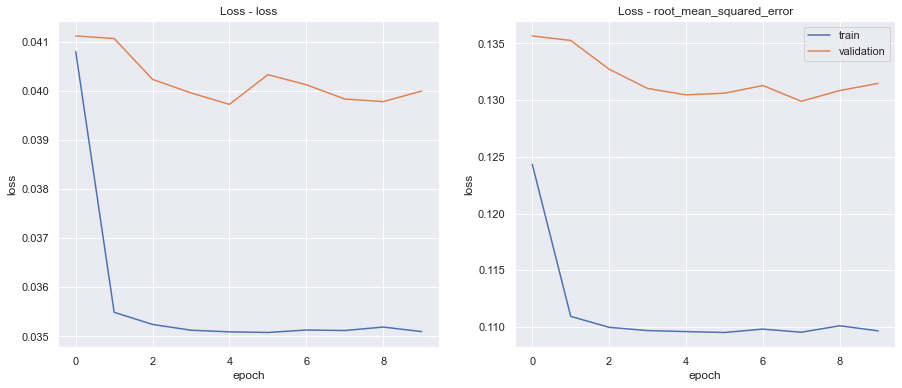

In [23]:
plot(history)

### Evaluate model and make predictions

In [24]:
# unscale data
def postprocess_coal(arr): return (arr * coal_train_std) + coal_train_mean

def postprocess_nuclear(arr): return (arr * nucl_train_std) + nucl_train_mean

def postprocess_ngas(arr): return (arr * ngas_train_std) + ngas_train_mean

In [25]:
def plot_predictions(model, X, y, start=0, end=100):
    preds = model.predict(X)
    
    coal_preds = postprocess_coal(preds[:, 0])
    nuclear_preds = postprocess_nuclear(preds[:, 1])
    ngas_preds = postprocess_ngas(preds[:, 2])
    
    coal_actuals = postprocess_coal(y[:, 0])
    nuclear_actual = postprocess_nuclear(y[:, 1])
    ngas_actual = postprocess_ngas(y[:, 2])
    
    df = DataFrame(data={
            'Coal predictions': coal_preds,
            'Nuclear predictions': nuclear_preds,
            'Natural gas predictions': ngas_preds
        })
    
    fig, axs = plt.subplots(1, 3, figsize=(25, 6))
    axs[0].plot(df['Coal predictions'][start:end], label='predict')
    axs[0].legend(loc="upper right")
    axs[0].plot(coal_preds[start:end], label='Actual')
    axs[0].legend(loc="upper left")
    axs[0].set_title("Coal source")

    axs[1].plot(df['Nuclear predictions'][start:end], label='predict')
    axs[1].legend(loc="upper right")
    axs[1].plot(nuclear_preds[start:end], label='Actual')
    axs[1].legend(loc="upper left")
    axs[1].set_title("Nuclear source")

    axs[2].plot(df['Natural gas predictions'][start:end], label='predict')
    axs[2].legend(loc="upper right")
    axs[2].plot(ngas_preds[start:end], label='Actual')
    axs[2].legend(loc="upper left")
    axs[2].set_title("Natural Gas source")

    plt.show()

6609/6609 [==============================] - 13s 2ms/step


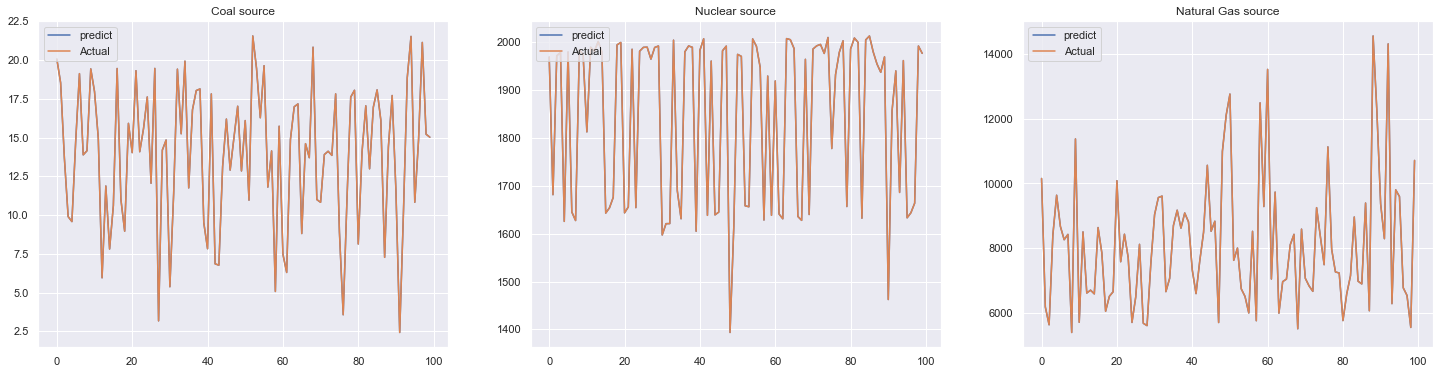

In [26]:
plot_predictions(model, X_train, y_train)

3256/3256 [==============================] - 6s 2ms/step


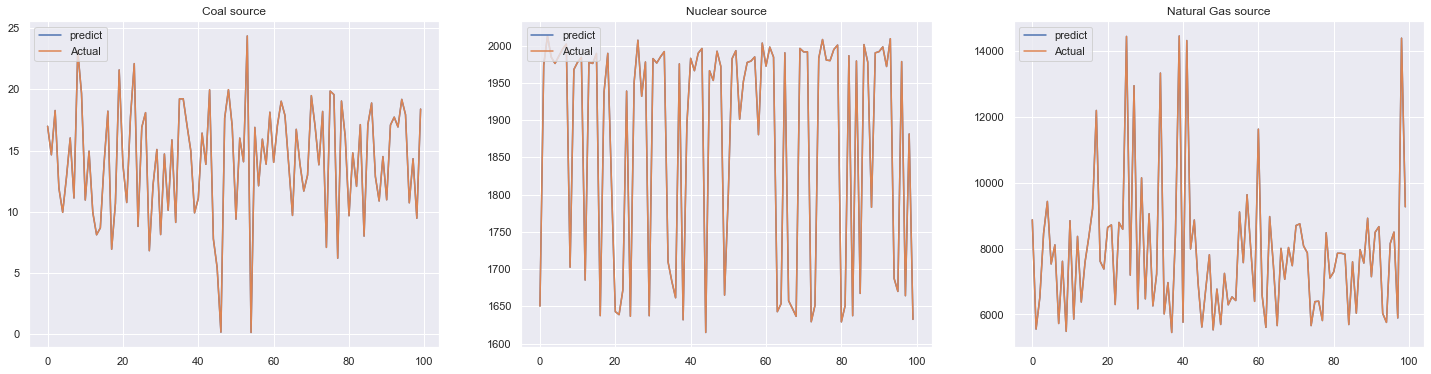

In [27]:
plot_predictions(model, X_test, y_test)